SHOW THAT UCB1 DOESN'T WORK FOR THIS ENVIRONMENT!!

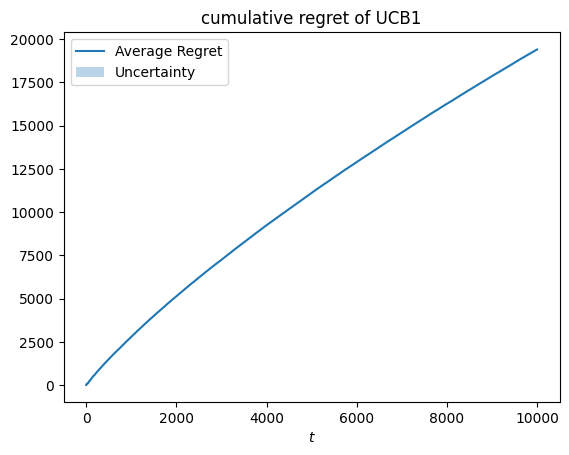

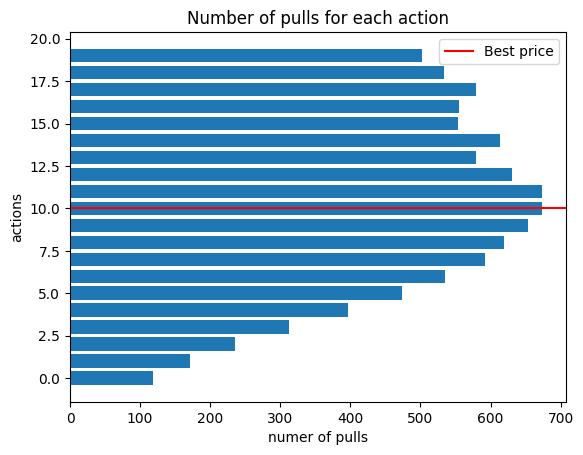

In [3]:
from pricing_environment import PricingEnvironment
from pricing import UCB1PricingAgent
from Demand_curve_generator import Demand_curve_generator as demand

from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    T = 10000 # number of days
    epsilon = T**(-0.33)
    K =  int(1/epsilon)# number of actions (see theory for the choice of K)
    n_customers = 100 #this would depend on advertising step

    prices = np.linspace(0,1,K) # 100 actions
    cost = 0.1 #To be chosen

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) #generates T parameters for the demand curve 1 for each day (ask if it could be more than one per day)
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    profit_curve = []
    for t in range(T):
        profit_curve.append(reward_function(prices, n_customers*conversion_rates[t](prices)))
    profit_curve = np.array(profit_curve)
    summed_profits = np.sum(profit_curve, axis=0)
    best_price_index = np.argmax(summed_profits)
    best_price = prices[best_price_index]
    expected_clairvoyant_rewards = profit_curve[:,best_price_index]

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost)
    Hedge_agent = UCB1PricingAgent(K, T, range=maximum_profit) #TODO I think we should use an adverarial regret minimizer here like exp3!!!

    agent_losses = np.array([])

    for t in range(T):
        pi_t = Hedge_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers, t)# modified envirnment function!!!
        Hedge_agent.update(r_t)

        agent_losses = np.append(agent_losses, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_losses)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), Hedge_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

TRY Hedge INSTEAD!

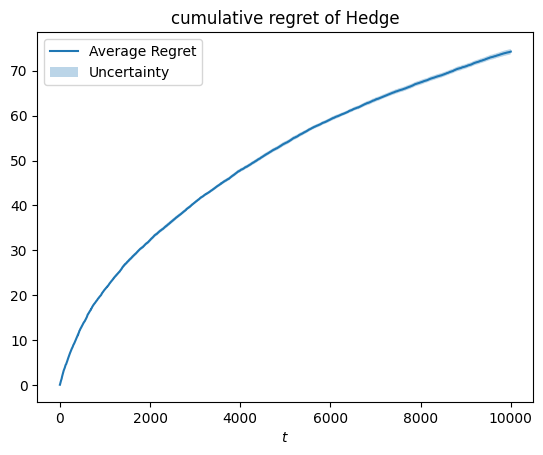

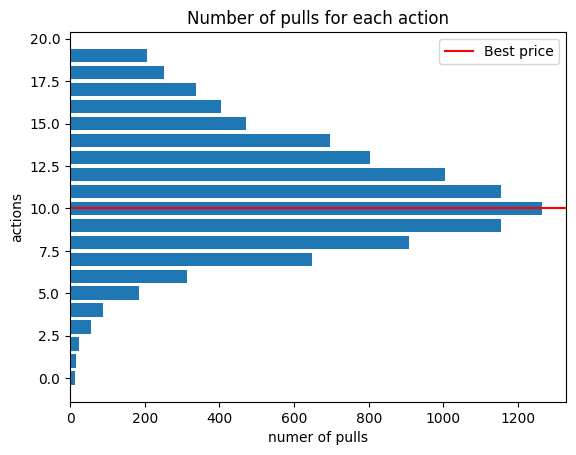

In [4]:
from pricing_environment import PricingEnvironment
from bidding import HedgeAgent
from Demand_curve_generator import Demand_curve_generator as demand

from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    T = 10000 # number of days
    epsilon = T**(-0.33)
    K =  int(1/epsilon)# number of actions (see theory for the choice of K)
    n_customers = 100 #this would depend on advertising step
    learning_rate = np.sqrt(np.log(K)/T)


    prices = np.linspace(0,1,K) # 100 actions
    cost = 0.1 #To be chosen

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) #generates T parameters for the demand curve 1 for each day (ask if it could be more than one per day)
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    profit_curve = []
    for t in range(T):
        #profit_curve.append(reward_function(prices, n_customers*conversion_rates[t](prices)))
        profit_curve.append([(1-(price-cost)*conversion_rates[t](price)) for price in prices])
    profit_curve = np.array(profit_curve)
    summed_profits = np.sum(profit_curve, axis=0)
    best_price_index = np.argmin(summed_profits)
    best_price = prices[best_price_index]
    expected_clairvoyant_rewards = profit_curve[:,best_price_index]

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost, prices=prices)
    Hedge_agent = HedgeAgent(K, learning_rate) #TODO I think we should use an adverarial regret minimizer here like exp3!!!

    agent_losses = np.array([])

    for t in range(T):
        pi_t = Hedge_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        l_t = env.round(p_t, n_customers, t) # modified envirnment function!!!
        Hedge_agent.update(l_t)

        agent_losses = np.append(agent_losses, l_t[pi_t])

    cumulative_regret = np.cumsum(agent_losses-expected_clairvoyant_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of Hedge')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), Hedge_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();